In [1]:
from numba import config

# set the threading layer before any parallel target compilation
config.THREADING_LAYER = "safe"

In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from helpers import subsample_train
from xgboost import XGBClassifier

from automated_scoring.classification import k_fold_predict
from automated_scoring.classification._optimization_utils import evaluate_results
from automated_scoring.classification.visualization import plot_classification_timeline
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import load_dataset
from automated_scoring.sliding_metrics import sliding_median
from automated_scoring.utils import ensure_generator
from automated_scoring.logging import set_logging_level

In [3]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [4]:
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)

2025-02-18 16:41:40.518 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-02-18 16:41:41.525 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [5]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml(
    "config_file.yaml"
)

In [6]:
# this cell is equivalent to smoothing_experiment-mice.py
# 5-fold cross-validation is performed num_iteration (20) times to average out stochasticity
# these iterations can be performed in parallel on a cluster (using mpi4py) as they don't depend on each other


from automated_scoring.classification.optimize import optimize_smoothing


def smooth(parameters, array):
    return sliding_median(array, parameters["median_filter_window"])


best_parameters = optimize_smoothing(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=100),
    smooth,
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 10)},
    remove_overlapping_predictions=False,
    num_iterations=2,
    k=5,
    sampling_func=subsample_train,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    results_path=".",
    log=set_logging_level("info"),
)

2025-02-18 16:41:41.903 [INFO    ] started smoothing optimization
2025-02-18 16:41:41.903 [INFO    ] [iteration: 0] started k-fold cross-validation
2025-02-18 16:41:41.951 [INFO    ] [iteration: 0] [fold: 0/5] started sampling
2025-02-18 16:41:42.927 [SUCCESS ] [iteration: 0] [fold: 0/5] finished sampling in 0.98 seconds
2025-02-18 16:41:42.956 [INFO    ] [iteration: 0] [fold: 0/5] started fitting XGBClassifier
2025-02-18 16:41:54.538 [SUCCESS ] [iteration: 0] [fold: 0/5] finished fitting XGBClassifier in 11.58 seconds
2025-02-18 16:41:54.539 [INFO    ] [iteration: 0] [fold: 0/5] started predicting on dataset
2025-02-18 16:41:54.967 [INFO    ] [iteration: 0] [fold: 0/5] [group: 0/14] [1/1] finished predictions
2025-02-18 16:41:54.967 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] finished predictions
2025-02-18 16:41:55.500 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] [1/1] finished predictions
2025-02-18 16:41:55.500 [INFO    ] [iteration: 0] [fold: 0/5] [group: 2/14] fini

In [7]:
best_parameters  # -> {"median_filter_window": 47}

({'median_filter_window_attack': 63.0},
 {'median_filter_window_investigation': 13.0},
 {'median_filter_window_mount': 23.0},
 {'median_filter_window_none': 13.0})

In [8]:
# redifine the smoothing function with the optimal parameter


def optimal_smooth(*, array):
    return sliding_median(array, int(best_parameters["median_filter_window"]))

In [ ]:
# this cell is equivalent to smoothing_experiment-mice.py
# (see comment above)

from automated_scoring.classification import optimize_decision_thresholds


best_thresholds = optimize_decision_thresholds(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=1000),
    remove_overlapping_predictions=False,
    smoothing_func=optimal_smooth,
    num_iterations=20,
    k=5,
    sampling_func=subsample_train,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    results_path=".",
    log=set_logging_level("info")
)

best_thresholds  # -> {"attack": 0.3, "investigation": 0.0, "mount": 0.0, "none": 0.0}

2025-02-18 11:12:15.923 [INFO    ] started decision threshold optimization
2025-02-18 11:12:15.924 [INFO    ] [iteration: 0] started k-fold cross-validation
2025-02-18 11:12:15.953 [INFO    ] [iteration: 0] [fold: 0/5] started sampling
2025-02-18 11:12:16.554 [SUCCESS ] [iteration: 0] [fold: 0/5] finished sampling in 0.60 seconds
2025-02-18 11:12:16.577 [INFO    ] [iteration: 0] [fold: 0/5] started fitting XGBClassifier
2025-02-18 11:13:47.981 [SUCCESS ] [iteration: 0] [fold: 0/5] finished fitting XGBClassifier in 91.40 seconds
2025-02-18 11:13:47.982 [INFO    ] [iteration: 0] [fold: 0/5] started predicting on dataset
2025-02-18 11:13:48.969 [INFO    ] [iteration: 0] [fold: 0/5] [group: 0/14] [1/1] finished predictions
2025-02-18 11:13:48.969 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] finished predictions
2025-02-18 11:13:50.013 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] [1/1] finished predictions
2025-02-18 11:13:50.013 [INFO    ] [iteration: 0] [fold: 0/5] [group: 2

In [ ]:
best_thresholds

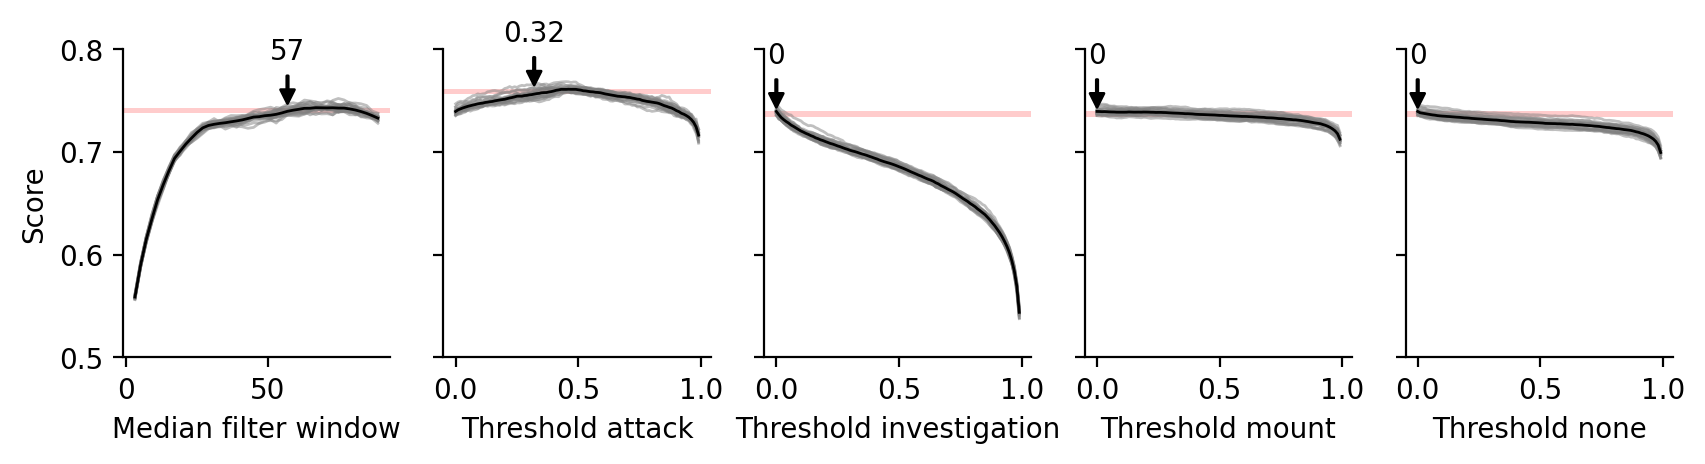

In [16]:
# instead, load results from smoothing_experiment-mice.py and thresholding_experiment-mice.py cluster runs

import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    1, len(dataset_train.categories) + 1, sharey=True, figsize=(10, 2)
)

smoothing_results = pd.read_csv("results_smoothing.csv", index_col=0)
evaluate_results(
    smoothing_results,
    parameter_names=["median_filter_window"],
    tolerance=0.005,
    plot_results=True,
    axes=axes[[0]],
)

for category_idx, category in enumerate(dataset_train.categories):
    thresholding_results_category = pd.read_csv(
        f"results_thresholding-{category}.csv", index_col=0
    )
    evaluate_results(
        thresholding_results_category,
        parameter_names=[f"threshold_{category}"],
        tolerance=0.005,
        plot_results=True,
        axes=axes[[category_idx + 1]],
    )

axes[0].set_yticks(np.arange(0.5, 0.9, 0.1))

for ax in axes[1:]:
    ax.set_ylabel("")

In [19]:
def optimal_smooth(*, array):
    return sliding_median(array, 57)

In [20]:
k_fold_result = k_fold_predict(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=1000, random_state=1),
    k=5,
    random_state=ensure_generator(1),
    sampling_func=subsample_train,
    log=set_logging_level("success"),
).smooth([optimal_smooth], decision_thresholds=[0.4, 0, 0, 0])

2025-02-18 15:25:39.015 [SUCCESS ] [fold: 0/5] finished sampling in 0.60 seconds
2025-02-18 15:27:31.392 [SUCCESS ] [fold: 0/5] finished fitting XGBClassifier in 112.35 seconds
2025-02-18 15:27:38.528 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 7.13 seconds
2025-02-18 15:27:39.532 [SUCCESS ] [fold: 1/5] finished sampling in 0.96 seconds
2025-02-18 15:29:32.049 [SUCCESS ] [fold: 1/5] finished fitting XGBClassifier in 112.48 seconds
2025-02-18 15:29:37.057 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 5.01 seconds
2025-02-18 15:29:38.023 [SUCCESS ] [fold: 2/5] finished sampling in 0.92 seconds
2025-02-18 15:31:26.381 [SUCCESS ] [fold: 2/5] finished fitting XGBClassifier in 108.32 seconds
2025-02-18 15:31:32.779 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 6.40 seconds
2025-02-18 15:31:33.762 [SUCCESS ] [fold: 3/5] finished sampling in 0.94 seconds
2025-02-18 15:33:22.606 [SUCCESS ] [fold: 3/5] finished fitting XGBClassifier in 108.81 seconds
2025-02-18

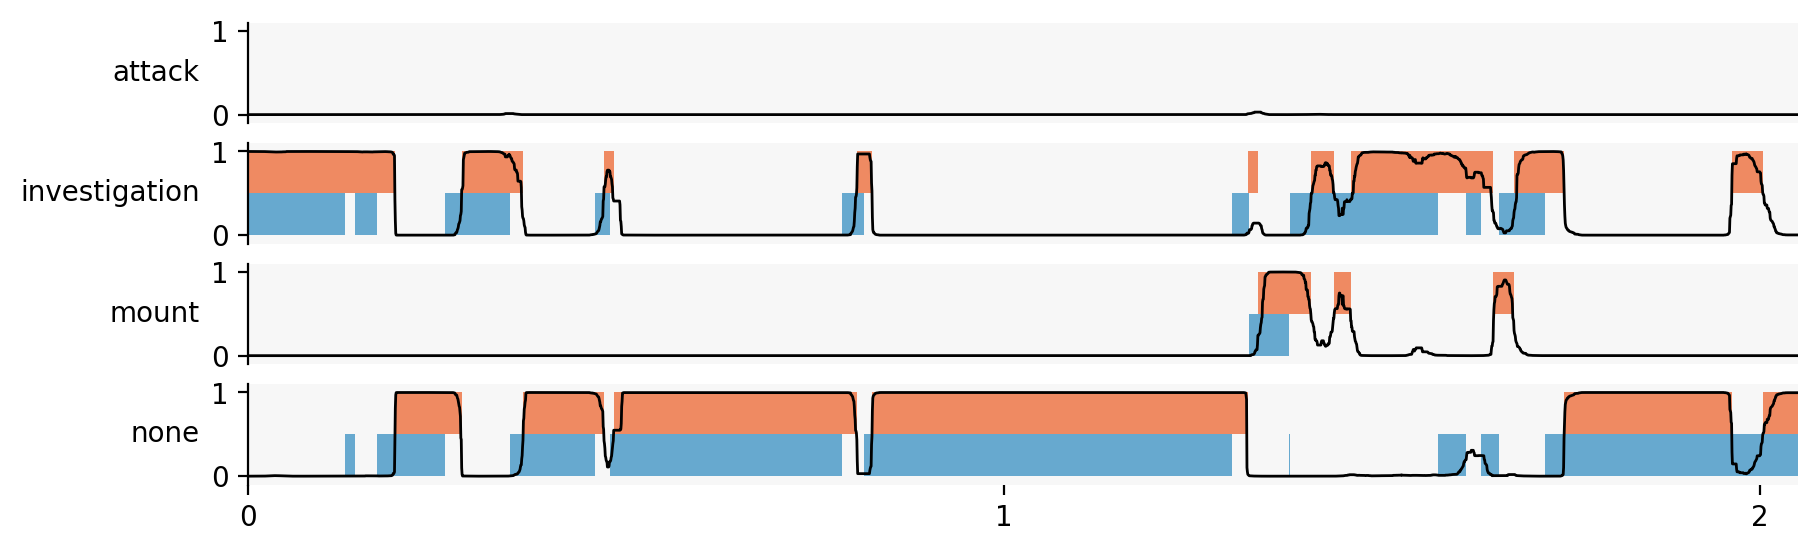

In [24]:
dyad_results = k_fold_result.classification_results[15].classification_results[
    ("resident", "intruder")
]

plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=dyad_results.y_proba,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)